# Algoritmo ALS para Recomendação On-line

Referência:

http://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering

http://www.slideshare.net/srowen/big-practical-recommendations-with-alternating-least-squares


## Objetivo

Entender a dinâmica do cálculo do ALS, testar alternativas para inicialização dos vetores de fatores latentes para novos usuários e novos documentos, testar alternativas para execução incremental do ALS.

In [1]:
using DataFrames, Gadfly
set_default_plot_size(24cm, 16cm)

In [2]:
u = 1000 # Number of Users
i = 50   # Number of Items
d = 0.03 # Density of Preferences (3%) 
m = 10.0 # Max Preference value

println("Number of users: $u")
println("Number of itens: $i")
println("Density of preferences: $d")
println("Max preferences value: $m")

sleep(0.11) # flush out

Number of users: 1000
Number of itens: 50
Density of preferences: 0.03
Max preferences value: 10.0


In [3]:
# random preferences (uniform distribution), users (lines) vs. items (columns)
A = rand(u,i)

1000x50 Array{Float64,2}:
 0.905546   0.30378    0.44454   …  0.57945    0.288269   0.849844 
 0.390313   0.637043   0.364996     0.899452   0.160286   0.298271 
 0.933257   0.524085   0.322088     0.0507796  0.40732    0.717741 
 0.951806   0.631891   0.31538      0.0726614  0.681915   0.444894 
 0.543798   0.853161   0.380077     0.450192   0.974259   0.0118247
 0.0425884  0.592908   0.689296  …  0.126826   0.483726   0.851847 
 0.0562744  0.851063   0.922165     0.181168   0.328492   0.318294 
 0.302448   0.479834   0.192419     0.736215   0.905834   0.148333 
 0.205732   0.113017   0.540207     0.54182    0.859516   0.381295 
 0.0179285  0.621748   0.143313     0.757355   0.0224229  0.299607 
 0.721778   0.317604   0.997279  …  0.184222   0.985843   0.447645 
 0.871985   0.0383857  0.690671     0.547492   0.66801    0.256226 
 0.109597   0.909029   0.856237     0.683946   0.819508   0.940293 
 ⋮                               ⋱                                 
 0.935263   0.604279  

In [4]:
# binary matrix (A is 0-1 uniform, so number of trues is equal to 'd' percentage)  
B = A .< d

1000x50 BitArray{2}:
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false   true
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
  true  false  false  false  false     false  false  false   true  false
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
     ⋮                        

In [5]:
# clean preferences (remove preferences above d)
C = A .* float(B)

1000x50 Array{Float64,2}:
 0.0        0.0  0.0  0.0          …  0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0118247
 0.0        0.0  0.0  0.0          …  0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 0.0179285  0.0  0.0  0.0             0.0  0.0  0.0  0.0224229  0.0      
 0.0        0.0  0.0  0.0          …  0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 0.0        0.0  0.0  0.0             0.0  0.0  0.0  0.0        0.0      
 ⋮          

In [6]:
# scale preferences (all values are below d and scaled to max m)
P = ceil(C * m / d)

1000x50 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   4.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  10.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 6.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  8.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   9.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0

Number of Preferences: 1489


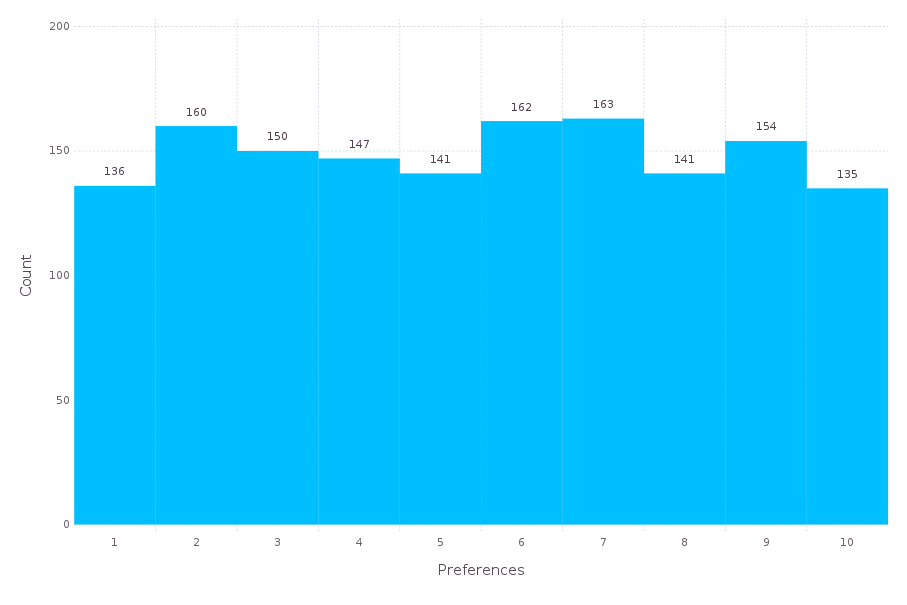

In [7]:
prefs = filter(v -> v != 0.0, P)
prefs = floor(Integer, prefs)

prefs_n = length(prefs)
bins = ceil(Int, m)
x, y = hist(prefs, bins)

x = round(Int, collect(x)[2:end])
x = map(string, x)

prefs_df = DataFrame(Preferences=x, Count=y, Label=map(string, y))
println("Number of Preferences: $prefs_n")
sleep(0.11) # flush out
plot(prefs_df,
    x="Preferences",
    y="Count",
    label="Label",
    Geom.label(position=:above),
    Geom.bar,
    Scale.y_continuous(minvalue=0))

In [8]:
# users summary

s(t) = symbol(t)

function user_stats(U)
    items = length(U)
    pref_max = maximum(U)
    pref_min = minimum(U)
    pref_mean = mean(U)
    Dict{Symbol, Number}(
        s("Number Of Items") => items,
        s("Min Preference") => pref_min,
        s("Max Preference") => pref_max,
        s("Mean Preference") => pref_mean,
    )
end

users_prefs = [ filter(v -> v != 0.0, P[k,:]) for k in 1:size(P,1) ]
users_prefs = filter(v -> length(v) > 0, users_prefs)
users_stats = [ user_stats(U) for U in users_prefs ]

users_df = DataFrame(users_stats)
users_n = nrow(users_df)

println("Number of Users: $users_n")
println()
describe(users_df)

sleep(0.11) # flush out

Number of Users: 771

Number Of Items
Min      1.0
1st Qu.  1.0
Median   2.0
Mean     1.9312581063553826
3rd Qu.  2.0
Max      6.0
NAs      0
NA%      0.0%

Mean Preference
Min      1.0
1st Qu.  4.0
Median   5.5
Mean     5.50380458279291
3rd Qu.  7.0
Max      10.0
NAs      0
NA%      0.0%

Max Preference
Min      1.0
1st Qu.  5.0
Median   7.0
Mean     6.59662775616083
3rd Qu.  9.0
Max      10.0
NAs      0
NA%      0.0%

Min Preference
Min      1.0
1st Qu.  2.0
Median   4.0
Mean     4.3916990920881975
3rd Qu.  7.0
Max      10.0
NAs      0
NA%      0.0%



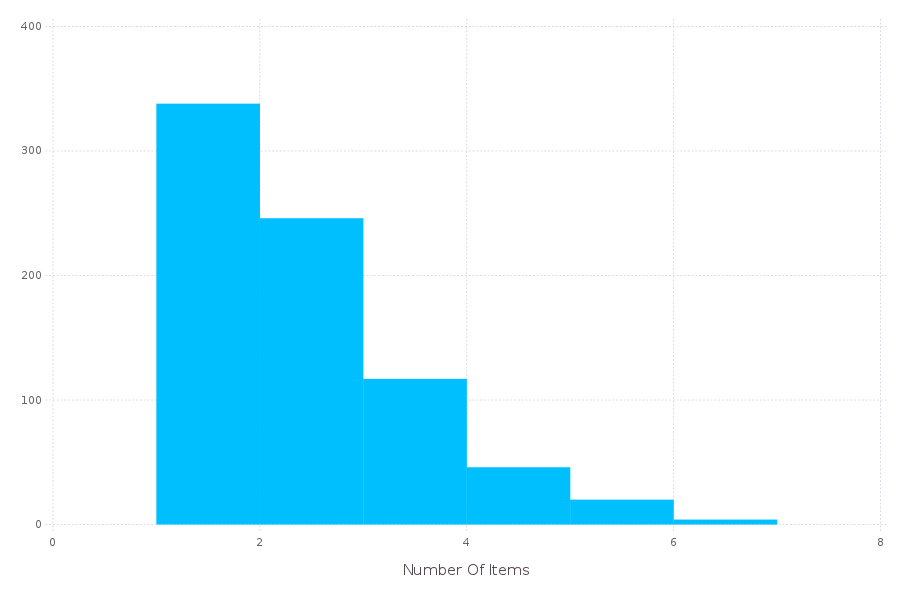

In [9]:
bins = maximum(users_df[s("Number Of Items")]) - minimum(users_df[s("Number Of Items")]) + 1
plot(users_df, x="Number Of Items", Geom.histogram(bincount=bins))

In [10]:
# items summary

function item_stats(I)
    users = length(I)
    pref_max = maximum(I)
    pref_min = minimum(I)
    pref_mean = mean(I)
    Dict{Symbol, Number}(
        s("Number Of Users") => users,
        s("Min Preference") => pref_min,
        s("Max Preference") => pref_max,
        s("Mean Preference") => pref_mean,
    )
end

items_prefs = [ filter(v -> v != 0.0, P[:,k]) for k in 1:size(P,2) ]
items_prefs = filter(v -> length(v) > 0, items_prefs)
items_stats = [ item_stats(I) for I in items_prefs ]

items_df = DataFrame(items_stats)

items_n = nrow(items_df)

println("Number of Items: $items_n")
println()
describe(items_df)

sleep(0.11) # flush out

Number of Items: 50

Mean Preference
Min      4.416666666666667
1st Qu.  5.173953201970443
Median   5.447817836812144
Mean     5.496664435173203
3rd Qu.  5.807539682539682
Max      6.724137931034483
NAs      0
NA%      0.0%

Number Of Users
Min      19.0
1st Qu.  26.0
Median   29.5
Mean     29.78
3rd Qu.  33.0
Max      45.0
NAs      0
NA%      0.0%

Max Preference
Min      9.0
1st Qu.  10.0
Median   10.0
Mean     9.96
3rd Qu.  10.0
Max      10.0
NAs      0
NA%      0.0%

Min Preference
Min      1.0
1st Qu.  1.0
Median   1.0
Mean     1.08
3rd Qu.  1.0
Max      2.0
NAs      0
NA%      0.0%



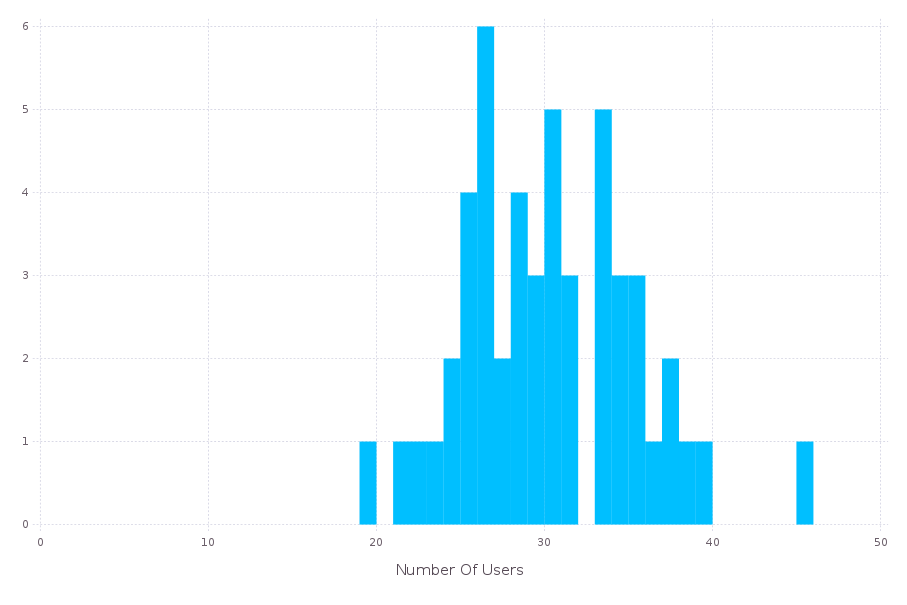

In [11]:
bins = maximum(items_df[s("Number Of Users")]) - minimum(items_df[s("Number Of Users")]) + 1
plot(items_df, x="Number Of Users", Geom.histogram(bincount=bins))

In [12]:
function mse(P, X, Y)
    M = float(P .> 0.0)
    E = P - M .* (X * Y')
    E2 = E .^ 2
    sum(E2) / countnz(P)
end

function als_plain(P, n_factors, n_iterations, λ)
    n_users, n_items = size(P)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)

    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        X = ((Y' * Y + reg) \ (Y' * P'))'
        Y = ((X' * X + reg) \ (X' * P))'
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_plain (generic function with 1 method)

In [13]:
factors = [10, 20, 100]
iterations = [10]
#iterations = [5, 15, 50]
lambdas = [0.01, 0.1, 1.0] 

testcases = vec([(f,i,λ) for f in factors, i in iterations, λ in lambdas])

new_result() = DataFrame([
    Int,     # Factors
    Int,     # Iterations
    Float64, # Lambda
    Float64, # Alpha
    Float64, # Last Error
    Float64, # Min Error
    Float64  # Max Error
    ], [
    :Factors,
    :Iterations,
    :λ,
    :α,
    :LastError,
    :MinError,
    :MaxError
], 0)

new_result (generic function with 1 method)

In [14]:
result = new_result()

g = Array(Layer, 0)

for (f, i, λ) in testcases
    #params = " $f, I=$i, λ=$λ "
    params = " $f, I=$i, lambda=$λ "
    print(params)

    @time _, _, errors = als_plain(P, f, i, λ)

    last = errors[end]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, 0.0, last, min, max])
            
    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sleep(0.11) # flush out

sort!(result, cols = :MinError)
result

 10, I=10, lambda=0.01   1.927541 seconds (1.79 M allocations: 104.308 MB, 1.66% gc time)
 20, I=10, lambda=0.01   0.033237 seconds (980 allocations: 24.369 MB, 14.19% gc time)
 100, I=10, lambda=0.01   0.070781 seconds (1.07 k allocations: 48.784 MB, 8.43% gc time)
 10, I=10, lambda=0.1   0.031434 seconds (980 allocations: 21.744 MB, 6.15% gc time)
 20, I=10, lambda=0.1   0.032219 seconds (980 allocations: 24.369 MB, 5.57% gc time)
 100, I=10, lambda=0.1   0.067140 seconds (1.07 k allocations: 48.784 MB, 5.54% gc time)
 10, I=10, lambda=1.0   0.032718 seconds (980 allocations: 21.744 MB, 7.47% gc time)
 20, I=10, lambda=1.0   0.034480 seconds (980 allocations: 24.369 MB, 5.31% gc time)
 100, I=10, lambda=1.0   0.069698 seconds (1.07 k allocations: 48.784 MB, 7.91% gc time)


,Factors,Iterations,λ,α,LastError,MinError,MaxError
1,100,10,0.01,0.0,3.6947226665826035e-6,3.6947226665826035e-6,4.275014075077122e-6
2,100,10,0.1,0.0,0.00016557949032512854,0.00016557949032512854,0.0003794533581506626
3,100,10,1.0,0.0,0.018838964895877244,0.012189042929572114,0.02457198242599298
4,20,10,0.1,0.0,11.221928098501692,11.061214412032896,12.478700193640282
5,20,10,0.01,0.0,11.30999621481178,11.187702717222558,12.47190646330191
6,20,10,1.0,0.0,11.483642331236283,11.335151030926546,12.750987116317106
7,10,10,1.0,0.0,20.875920547837833,20.80159199181738,22.600563405369208
8,10,10,0.1,0.0,20.843269505004933,20.820165581511205,22.77879140930636
9,10,10,0.01,0.0,20.987860561125206,20.97884092233027,22.55207364825292


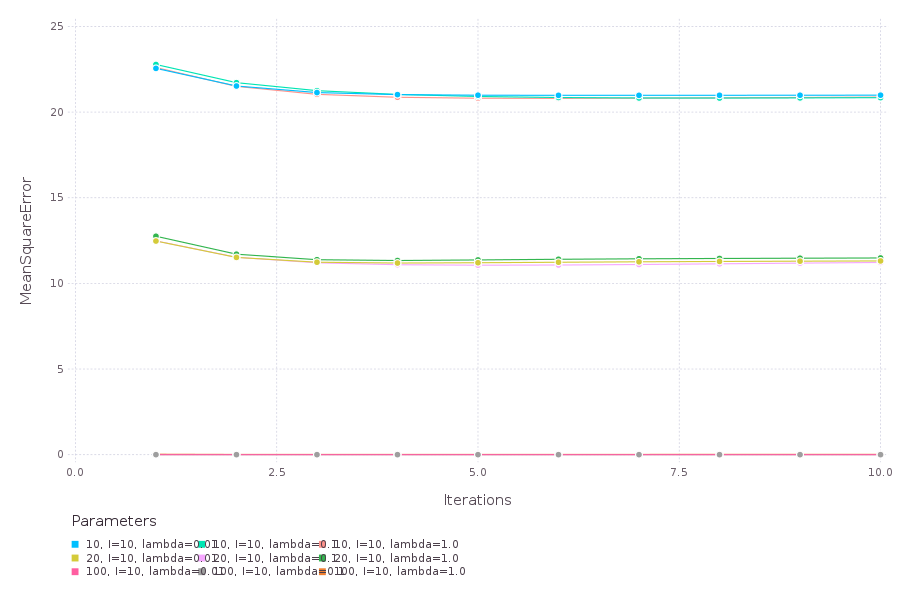

In [15]:
plot(g, Theme(key_position=:bottom))

In [16]:
function als_weighted(P, n_factors, n_iterations, λ)
    n_users, n_items = size(P)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)
    
    W = float(P .> 0.0)
    Wu = [diagm(vec(W[k,:])) for k in 1:n_users]
    Wi = [diagm(W[:,k]) for k in 1:n_items]
    
    Pu = [vec(P[k,:]) for k in 1:n_users]
    Pi = [P[:,k] for k in 1:n_items]
    
    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        for k in 1:n_users
            Wuk = Wu[k]
            X[k,:] = ((Y' * Wuk * Y + reg) \ (Y' * Wuk * Pu[k]))'
        end
        for k in 1:n_items
            Wik = Wi[k]
            Y[k,:] = ((X' * Wik * X + reg) \ (X' * Wik * Pi[k]))'
        end
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_weighted (generic function with 1 method)

In [17]:
result = new_result()

g = Array(Layer, 0)

for (f, i, λ) in testcases
    #params = " $f, I=$i, λ=$λ "
    params = " $f, I=$i, lambda=$λ "
    print(params)
    
    @time _, _, errors = als_weighted(P, f, i, λ)

    last = errors[end]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, 0.0, last, min, max])

    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sleep(0.11) # flush out

sort!(result, cols = :MinError)
result

 10, I=10, lambda=0.01   5.570922 seconds (537.18 k allocations: 778.103 MB, 7.71% gc time)
 20, I=10, lambda=0.01   5.349660 seconds (273.88 k allocations: 1.114 GB, 8.55% gc time)
 100, I=10, lambda=0.01  12.309327 seconds (343.09 k allocations: 5.613 GB, 7.24% gc time)
 10, I=10, lambda=0.1   5.159268 seconds (273.88 k allocations: 766.295 MB, 8.18% gc time)
 20, I=10, lambda=0.1   5.012386 seconds (273.88 k allocations: 1.114 GB, 9.20% gc time)
 100, I=10, lambda=0.1  12.217015 seconds (343.09 k allocations: 5.613 GB, 7.06% gc time)
 10, I=10, lambda=1.0   5.201976 seconds (273.88 k allocations: 766.295 MB, 8.33% gc time)
 20, I=10, lambda=1.0   4.960167 seconds (273.88 k allocations: 1.114 GB, 9.00% gc time)
 100, I=10, lambda=1.0  12.240128 seconds (343.09 k allocations: 5.613 GB, 7.16% gc time)


,Factors,Iterations,λ,α,LastError,MinError,MaxError
1,20,10,0.01,0.0,6.144294525693292e-7,6.144294525693292e-7,1.112042138437965e-6
2,100,10,0.01,0.0,8.384377989212367e-6,8.384377989212367e-6,9.27052501576756e-6
3,10,10,0.01,0.0,3.841781376087302e-5,3.841781376087302e-5,0.00018224758660611055
4,20,10,0.1,0.0,5.2015552903209174e-5,5.045928176267998e-5,0.00010958723408065402
5,10,10,0.1,0.0,0.0003394586240896176,0.0003394586240896176,0.00931055178823961
6,100,10,0.1,0.0,0.00048421048636428565,0.00048421048636428565,0.0006307625839507828
7,20,10,1.0,0.0,0.020496040977130946,0.009112065389574642,0.020496040977130946
8,10,10,1.0,0.0,0.020878046202788245,0.015184359598937788,0.14196888866328453
9,100,10,1.0,0.0,0.03361424748385781,0.03361424748385781,0.04254307362540453


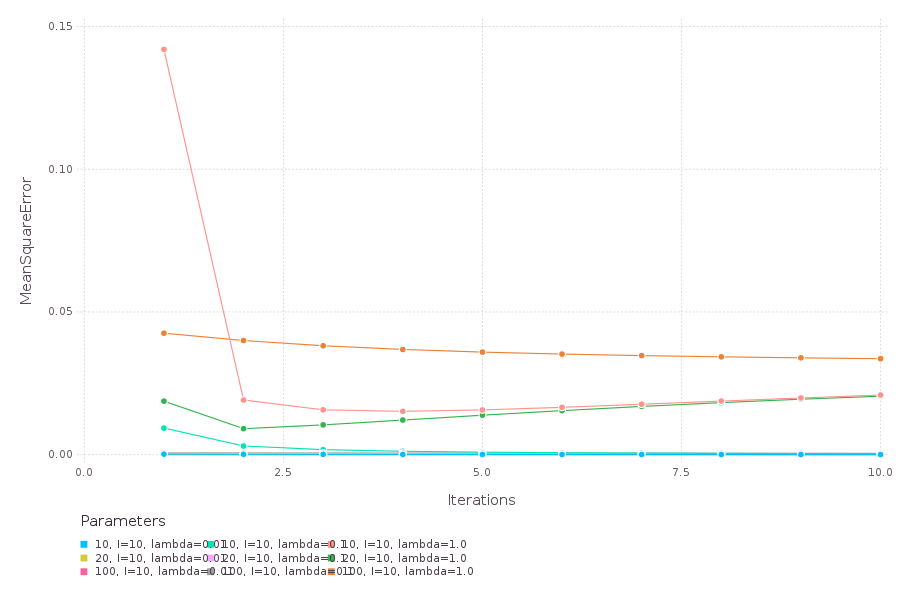

In [18]:
plot(g, Theme(key_position=:bottom))

In [19]:
function als_implicit(R, n_factors, n_iterations, λ, α)
    n_users, n_items = size(R)
    
    errors = Array(Float64, n_iterations)

    X = rand(n_users, n_factors)
    Y = rand(n_items, n_factors)
    
    P = float(R .> 0.0)

    C = P + α * R
    Cu = [diagm(vec(C[k,:])) for k in 1:n_users]
    Ci = [diagm(C[:,k]) for k in 1:n_items]
    
    Pu = [vec(P[k,:]) for k in 1:n_users]
    Pi = [P[:,k] for k in 1:n_items]
    
    reg = λ * eye(n_factors)
    for i in 1:n_iterations
        for k in 1:n_users
            Cuk, Puk = Cu[k], Pu[k]
            X[k,:] = ((Y' * Cuk * Y + reg) \ (Y' * Cuk * Puk))'
        end
        for k in 1:n_items
            Cik, Pik = Ci[k], Pi[k]
            Y[k,:] = ((X' * Cik * X + reg) \ (X' * Cik * Pik))'
        end
        errors[i] = mse(P, X, Y)
    end

    X, Y, errors
end

als_implicit (generic function with 1 method)

In [20]:
result = new_result()

g = Array(Layer, 0)

implicit_tests = vec([(f,20,λ,α) for f in 10, λ in [0.01,1.0,10.0], α in [0.,0.01,2.,50.]])

for (f, i, λ, α) in implicit_tests
    #params = " $f, I=$i, λ=$λ, α=$α "
    params = " $f, I=$i, lambda=$λ, alpha=$α "
    print(params)
    
    @time _, _, errors = als_implicit(P, f, i, λ, α)

    last = errors[end]
    min = minimum(errors)
    max = maximum(errors)

    push!(result, [f, i, λ, α, last, min, max])

    df = DataFrame(Iterations=1:i, MeanSquareError=errors, Parameters=params)
    pl = layer(df, x=:Iterations, y=:MeanSquareError, color=:Parameters, Geom.line, Geom.point)
    push!(g, pl...)
end

sleep(0.11) # flush out

sort!(result, cols = :LastError)
result

 10, I=20, lambda=0.01, alpha=0.0   9.916062 seconds (624.74 k allocations: 1.108 GB, 4.65% gc time)
 10, I=20, lambda=1.0, alpha=0.0   9.903726 seconds (535.35 k allocations: 1.104 GB, 4.69% gc time)
 10, I=20, lambda=10.0, alpha=0.0   9.970272 seconds (535.35 k allocations: 1.104 GB, 4.96% gc time)
 10, I=20, lambda=0.01, alpha=0.01   9.940562 seconds (535.35 k allocations: 1.104 GB, 4.67% gc time)
 10, I=20, lambda=1.0, alpha=0.01   9.853942 seconds (535.35 k allocations: 1.104 GB, 4.70% gc time)
 10, I=20, lambda=10.0, alpha=0.01  10.090476 seconds (535.35 k allocations: 1.104 GB, 4.84% gc time)
 10, I=20, lambda=0.01, alpha=2.0   9.914418 seconds (535.35 k allocations: 1.104 GB, 4.72% gc time)
 10, I=20, lambda=1.0, alpha=2.0   9.881975 seconds (535.35 k allocations: 1.104 GB, 4.70% gc time)
 10, I=20, lambda=10.0, alpha=2.0   9.863782 seconds (535.35 k allocations: 1.104 GB, 4.86% gc time)
 10, I=20, lambda=0.01, alpha=50.0   9.972857 seconds (535.35 k allocations: 1.104 GB, 4.71

,Factors,Iterations,λ,α,LastError,MinError,MaxError
1,10,20,0.01,50.0,4.6196745451114287e-10,4.6196745451114287e-10,4.788673115790008e-10
2,10,20,0.01,2.0,1.309538390489614e-7,1.309538390489614e-7,1.483188434130676e-7
3,10,20,1.0,50.0,3.002769053443274e-6,3.002769053443274e-6,3.934862754525742e-6
4,10,20,0.01,0.01,3.233284884797796e-6,3.233284884797796e-6,4.008137521180831e-6
5,10,20,0.01,0.0,3.6116407331324223e-6,3.6116407331324223e-6,5.547114171035105e-6
6,10,20,10.0,50.0,0.0001547439719079354,0.0001547439719079354,0.00027034786064667306
7,10,20,1.0,2.0,0.00040481086666025926,0.00040481086666025926,0.0008719340185525961
8,10,20,1.0,0.01,0.019157901424213537,0.01898234025844422,0.02248213674679125
9,10,20,1.0,0.0,0.02121020809546645,0.02117883230296808,0.024827135040603347
10,10,20,10.0,2.0,0.024567758134215564,0.02456717570084614,0.02993763730927105


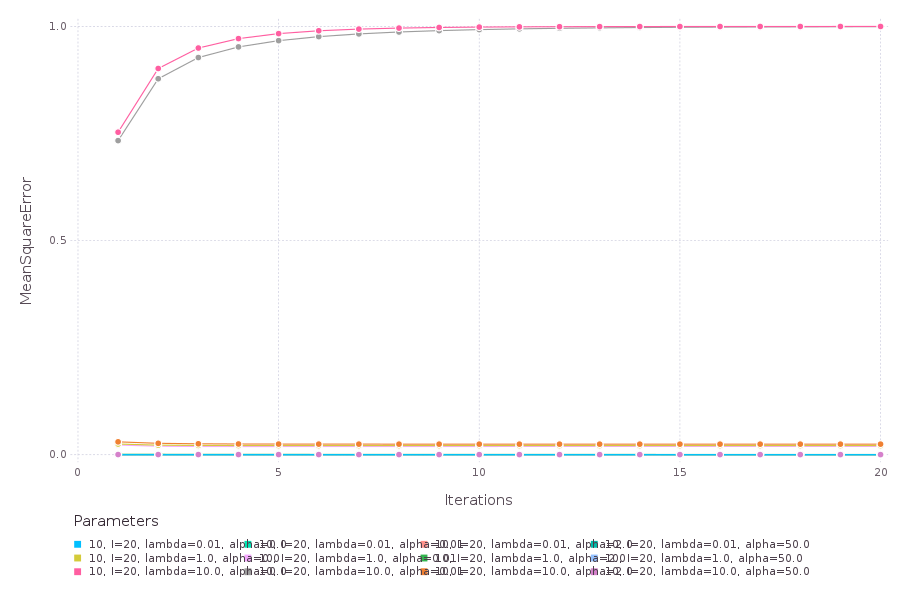

In [21]:
plot(g, Theme(key_position=:bottom))